# Optimization

The optimization problem is posed as an optimization objective (e.g. cost function, loss, etc) to either minimize or maximize. We turn the knobs we have to move our objective in the desired direction.

When we model data, our "knobs" control the parameters of our model, and our objective is minimizing the discrepancy between our model's expectation of the data and the data itself. By minimizing this difference, we "fit" the model to the data.

## Aside
We are mainly concerned with single-objective optimization. Even when given seemingly disparate objectives, we typically can weigh the different costs and combine them into a single objective. When we have unreconcileable objectives, we can optimize for a pareto-front (set) of optimal parameters instead of a single solution.


## Linear Regression

Linear regression is a very basic data modeling problem. Each of $N$ data points is described by the pair $(x_i,y_i)$, and as the name suggests, our task is to find the line of best fit for this data. Our model is a line, which given an $x_i$, predicts a $\hat y_i$. The "regression" part of the name indicates that we are predicting continuous valued $y_i$, as opposed ot discrete values that we could classify over (known as classification).

We describe the "best fit" formally as a cost function which minimizes the mean sum of squared errors between predicted and true $y$-values. Individual errors $\hat y - y$ are called residuals. Then, the whole error is
$$
    J = \frac{1}{N} \Sigma_{i=1}^N (\hat y_i - y_i)^2.
$$

Our model, a line, is characterized by its slope and y-intercept (2 degrees of freedom). Since each $\hat y_i$ is modeled by $y = mx+b$, we can parameterize the error in terms of our model parameters. 
$$
    J(m,b) = \frac{1}{N} \Sigma_{i=1}^N (mx_i + b - y_i)^2.
$$

Let's take a look at this in code.

In [121]:
# Linear Regression - fit points with a line
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def predict(params, data):
    r"""
        args:
            params: (m,b) tuple
            data: N x 2 array (x,y tuples)
    """
    m, b = params
    x = data[:, 0]
    return m * x + b
def regression_error(params, data):
    r"""
        args: 
            params: (m,b) tuple
            data: (x,y) tuples to fit
    """
    error = (predict(params, data) - data[:, 1])**2
    return error.mean()


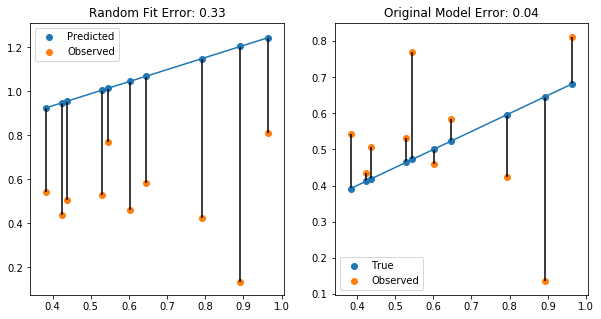

In [122]:
# Generate noised data, plot it with the original line and get the residuals
# We can use linear regression to get linear models even of nonlinear processes! 
# Though in general, you should be qualifying conclusions about the data with modeling assumptions

np.random.seed(0)
n = 10
true_model_params = (0.5, .2) # m = 2, b = 3
params = np.random.sample(2)

x = np.random.sample(n)
x.sort()
y_unnoised = true_model_params[0] * x + true_model_params[1]
y_noised = y_unnoised + 0.2 * np.random.randn(n)
y_predicted = params[0] * x + params[1]

fig, ax = plt.subplots(1,2, figsize=(10, 5))

data = np.array(list(zip(x, y_noised)))
best_error = regression_error(true_model_params, data)
prediction_error = regression_error(params, data)

ax[0].set_title(f"Random Fit Error: {prediction_error:.2f}")
ax[0].scatter(x, y_predicted, label="Predicted")
ax[0].scatter(x, y_noised, label="Observed")
ax[0].plot(x, y_predicted)
ax[0].vlines(x, y_predicted, y_noised)
ax[0].legend()

ax[1].set_title(f"Original Model Error: {best_error:.2f}")
ax[1].scatter(x, y_unnoised, label="True")
ax[1].scatter(x, y_noised, label="Observed")
ax[1].plot(x, y_unnoised)
ax[1].vlines(x, y_unnoised, y_noised)
ax[1].legend()



## Linear Regression as Optimization

Our regression error (also known as mean squared error) is a function of our line parmaeters; we want to minimize the error to get the best linear fit. It's an optimization problem!
Knowing how to optimize (turn the knobs on) a given model would clearly be of great value, and so people have come up with many different techniques. Depending on the class of model (e.g. a line, a convex surface) being used, special purpose algorithms can even have provably good convergence rates. In linear regression, we can actually solve explicitly for a solution thanks to linear algebra. However, we are interested in a more generic algorithm.

Much of the progress we've seen in data modeling in the past decade has been driven by variations on a simple algorithm called gradient descent. 

Before we start on gradient descent, let's get some intuition for the algorithm. Since here, our cost is a function of two parameters, we can visualize it in 3D.

Min error: 0.0323
Min error: [-0.1        0.6        0.0323102]


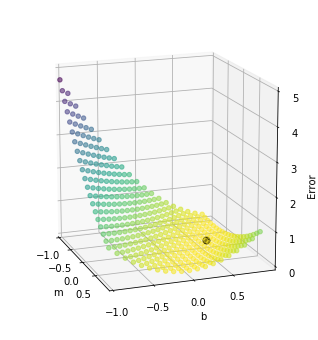

In [275]:
# note to self: default azimuth is -60, and elevation is 30
from mpl_toolkits.mplot3d import Axes3D

# Visualize the cost surface i.e. J as a function
# Using the same data from before
m_range = b_range = np.arange(-1, 1, 0.1)
m_vals, b_vals = np.meshgrid(m_range, b_range)
m_vals = m_vals.flatten()
b_vals = b_vals.flatten()
params_set = list(zip(m_vals, b_vals))
points = []
for params in params_set:
    points.append([params[0], params[1], regression_error(params, data)])
points = np.array(points)

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(121, projection='3d')
ax.view_init( azim=-20, elev = 15 )
ax.set_xlabel('m')
ax.set_xticks(np.arange(-1, 1, .5))
ax.set_yticks(np.arange(-1, 1, .5))
ax.set_ylabel('b')
ax.set_zlabel('Error')
ax.set_ylim3d(-1, 1)
ax.set_xlim3d(-1, 1)
ax.set_zlim3d(0, 5)

best_index = np.argmin(points[:, 2])
best_point = points[best_index: best_index + 1].T
print(f"Min error: {points[:,2][best_index]:.4f}")
print(f"Min error: {points[best_index]}")
ax.scatter( *points.T, c=1 - points.T[2], alpha=0.55)
ax.scatter( *best_point, c='black', s=50)


## Aside

You might have noticed the minimum error parameters from this grid are different from the parameters of the true line! The noise has caused a specious pattern that our algorithm can learn. When our models pick up on this noise, we "overfit" to the data. This is a separate concern, however.

# Gradient Descent

Gradient descent is an iterative optimization algorithm which updates our parameters at each timestep according to the gradient of our cost function. Formally:

$$ \theta_{t+1} = \theta_{t} - \gamma \nabla J(\theta_t).$$ 

In this equation, $\theta_t$ represents the parameters ($m,b$ for us so far) at time $t$, and we step in the direction opposite the gradient (which points in the direction of steepest change/ascent), which is the best local choice for minimizing our function. $\gamma$ controls the step size, which needs to tuned per modelling problem. Step size can correlate with how confident we can be in our local gradient approximation.

## Linear Regression as Gradient Descent

Returning to our cost function, we can calculate the gradient. (Mathematical derivations aside) we have the following function:
$$
\frac{\partial J}{\partial m} = \frac{1}{N}\Sigma 2(mx + b - y)(x)
$$
$$
\frac{\partial J}{\partial b} = \frac{1}{N}\Sigma 2(mx + b - y)
$$
Our code is quite a bit simpler, since we already have a mean error function. 

In [229]:
def gradient(params, data):
    error = predict(params, data) - data[:, 1]
    db = (error * 2).mean()
    dm = (error * 2 * data[:, 0]).mean()
    return np.array(dm, db)

def gradient_descent(params, data, gamma=0.01, iters=500, print_interval=5):
    params = np.array(params)
    for i in range(iters):
        params -= gamma * gradient(params, data)
        if i % print_interval == 0:
            print(f"Iter {i}: error - {regression_error(params, data):3f}")
    return params

In [230]:
np.random.seed(0)
params = np.random.sample(2)
gradient_descent(params, data, iters=150)

Iter 0: error - 0.319879
Iter 5: error - 0.264718
Iter 10: error - 0.220147
Iter 15: error - 0.184142
Iter 20: error - 0.155066
Iter 25: error - 0.131591
Iter 30: error - 0.112646
Iter 35: error - 0.097363
Iter 40: error - 0.085038
Iter 45: error - 0.075105
Iter 50: error - 0.067102
Iter 55: error - 0.060660
Iter 60: error - 0.055477
Iter 65: error - 0.051311
Iter 70: error - 0.047964
Iter 75: error - 0.045279
Iter 80: error - 0.043127
Iter 85: error - 0.041404
Iter 90: error - 0.040027
Iter 95: error - 0.038928
Iter 100: error - 0.038053
Iter 105: error - 0.037357
Iter 110: error - 0.036805
Iter 115: error - 0.036369
Iter 120: error - 0.036025
Iter 125: error - 0.035756
Iter 130: error - 0.035545
Iter 135: error - 0.035382
Iter 140: error - 0.035255
Iter 145: error - 0.035159


array([0.22303258, 0.38940845])

# Learning Rate

The step size we take in gradient descent describes how much we trust our current location's gradient, how much signal we take from it. In other words, it describes how much we learn from this location.

Besides having a fixed learning rate, we can apply different biases to affect how quickly we can optimize our problem, and to how good of a solution we converge to. In the above algorithm, we actually converge to an error above the optimal value we found in grid search of hyperparameters. This is because we're oscillating around the optimal solution.

A simple scheme to overcome this anneals the learning rate, so that it decreases over time. This intuitively allows the model to be optimized much quicker over obviously bad solutions, and be more careful about model updates as we approach optimality. The different mechanisms each have their own advantages, and we won't go into them here. However, you can look at the bottom of [this page](http://cs231n.github.io/neural-networks-3/) for some visualizations of well-known learning rate schemes.


In [220]:
def gradient_descent_annealed(params, data, lr_init=0.01, iters=500, print_interval=5):
    params = np.array(params)
    for i in range(iters):
        lr = lr_init * (1 - i / iters)
        params -= lr * gradient(params, data)
        if i % print_interval == 0:
            print(f"Iter {i}: error - {regression_error(params, data):3f}")
    return params

In [283]:
np.random.seed(0)
params = np.random.sample(2) # * 5 - 2.5
print(gradient_descent_annealed(params, data, lr_init=.1, iters=20000, print_interval=100))
# Note: Not converging to the best solution since these params init to [0,1) whereas the grid is [-1, 1]. Gradient descent never gets out of here.s

Iter 0: error - 0.348072
Iter 100: error - 0.032560
Iter 200: error - 0.032560
Iter 300: error - 0.032560
Iter 400: error - 0.032560
Iter 500: error - 0.032560
Iter 600: error - 0.032560
Iter 700: error - 0.032560
Iter 800: error - 0.032560
Iter 900: error - 0.032560
Iter 1000: error - 0.032560
Iter 1100: error - 0.032560
Iter 1200: error - 0.032560
Iter 1300: error - 0.032560
Iter 1400: error - 0.032560
Iter 1500: error - 0.032560
Iter 1600: error - 0.032560
Iter 1700: error - 0.032560
Iter 1800: error - 0.032560
Iter 1900: error - 0.032560
Iter 2000: error - 0.032560
Iter 2100: error - 0.032560
Iter 2200: error - 0.032560
Iter 2300: error - 0.032560
Iter 2400: error - 0.032560
Iter 2500: error - 0.032560
Iter 2600: error - 0.032560
Iter 2700: error - 0.032560
Iter 2800: error - 0.032560
Iter 2900: error - 0.032560
Iter 3000: error - 0.032560
Iter 3100: error - 0.032560
Iter 3200: error - 0.032560
Iter 3300: error - 0.032560
Iter 3400: error - 0.032560
Iter 3500: error - 0.032560
Iter

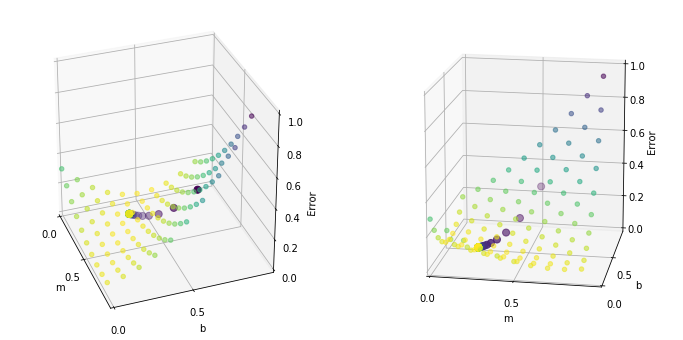

In [286]:
# We can see our algorithm learning using the same visualization as before

# Gather the parameters from the algorithm
np.random.seed(0)
params = np.random.sample(2)
trajectory = []
lr_init = 0.01
iters = 1000
for i in range(iters):
    lr = lr_init * (1 - i / iters)
    params -= lr * gradient(params, data)
    error = regression_error(params, data)
    if i % 20 == 0:
        trajectory.append([*params, error])
        
trajectory = np.array(trajectory)

m_range = b_range = np.arange(0, 1, 0.1)
m_vals, b_vals = np.meshgrid(m_range, b_range)
m_vals = m_vals.flatten()
b_vals = b_vals.flatten()
params_set = list(zip(m_vals, b_vals))
points = []
for params in params_set:
    points.append([params[0], params[1], regression_error(params, data)])
points = np.array(points)

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(121, projection='3d')
ax.view_init( azim=-20, elev = 30 )
ax.set_xlabel('m')
ax.set_xticks(np.arange(0, 1, .5))
ax.set_yticks(np.arange(0, 1, .5))
ax.set_ylabel('b')
ax.set_zlabel('Error')
ax.set_ylim3d(0, 1)
ax.set_xlim3d(0, 1)
ax.set_zlim3d(0, 1)

ax.scatter( *points.T, c=1 - points.T[2], alpha=0.55)
ax.scatter( *trajectory.T, c=np.arange(len(trajectory)), s=50)

ax = fig.add_subplot(122, projection='3d')
ax.view_init( azim=-80, elev = 15 )
ax.set_xlabel('m')
ax.set_xticks(np.arange(0, 1, .5))
ax.set_yticks(np.arange(0, 1, .5))
ax.set_ylabel('b')
ax.set_zlabel('Error')
ax.set_ylim3d(0, 1)
ax.set_xlim3d(0, 1)
ax.set_zlim3d(0, 1)

ax.scatter( *points.T, c=1 - points.T[2], alpha=0.55)
time = np.arange(0, 1, 1.0/trajectory.shape[0])
ax.scatter( *trajectory.T, c=time, s=50)
